<a href="https://colab.research.google.com/github/sanae-a11y/AI/blob/main/3d_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librairies

In [1]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 660 kB 31.6 MB/s 


In [2]:
import os
import glob
import trimesh
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)

#Importation des données

In [3]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 4s 0us/step


#Visualisation

In [4]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0085.off"))
mesh.show()

(2048, 3)


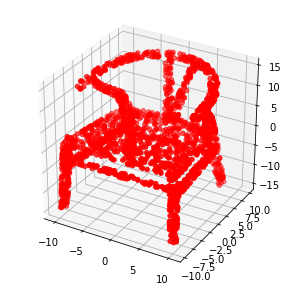

In [5]:
points = mesh.sample(2048)
print(points.shape)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],color='red')
#ax.set_axis_off()
plt.show()

In [6]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bathtub
processing class: night_stand
processing class: table
processing class: dresser
processing class: toilet
processing class: monitor
processing class: sofa
processing class: chair
processing class: desk
processing class: bed


In [8]:

train_points.shape

(3991, 2048, 3)

In [21]:
data_augm = pd.read_csv("Merged file.csv")

In [22]:
#A tf.Tensor represents a multidimensional array of elements.
data1 = np.asarray(data_augm)
data = np.zeros((159,2048,3))
for i in range(data.shape[0]):
  x= data1[i,:]
  for j in range(2048):
    str1 = x [j] 
    a = str1.split('(')
    b = a[1].split(',')
    m = np.array(np.matrix(b[0])).ravel()
    data[i,j,:] = m

In [28]:
train_points1

array([-1.68000000e+02, -7.59425495e+00,  4.72301046e+01, ...,
        3.96797060e-01,  5.53614000e-03,  9.66844500e-01])

In [37]:
b=train_points


In [39]:
b.shape

(3991, 2048, 3)

In [36]:
a=data
a.shape

(159, 2048, 3)

In [13]:
import pandas as pd
labels = pd.read_csv("labels.csv")

In [14]:
labels.shape

(159, 1)

In [15]:
label = np.transpose(np.asarray(labels))
label.shape

(1, 159)

In [9]:
train_labels.shape

(3991,)

In [16]:
train_labels1=np.append(train_labels,label)
train_labels1.shape

(4150,)

In [41]:
BATCH_SIZE = 32
def augment(points, label):
    # jitter points
    #points == objet (Nx3) associer a une classe 50xNx3
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))


train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

#Fonction Utiles 

In [18]:
def conv_bn(x, filters):
    # x: c'est l'input de taille Nx3 
    # filter de taille 1xfilters  --> output Nxfilters
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    #Batch Normalization applique une transformation qui maintient la sortie moyenne proche de 0 et l'écart type de sortie proche de 1
    #batch normalization affects the output of the previous activation layer by subtracting the batch mean, and then dividing by the batch’s standard deviation.
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x) #x > 0


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [19]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

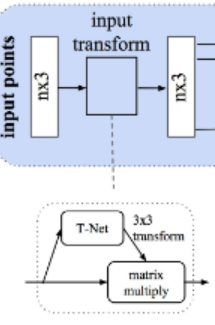

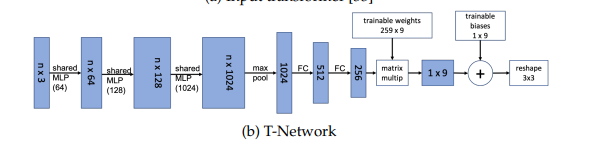

#Model

In [20]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten()) #Id3
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    #matrice 3 x 3
    feat_T = layers.Reshape((num_features, num_features))(x)
    #matrice d'input nx3 multiplier par une matrice 3x3 --> output matrice de taille nx3
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

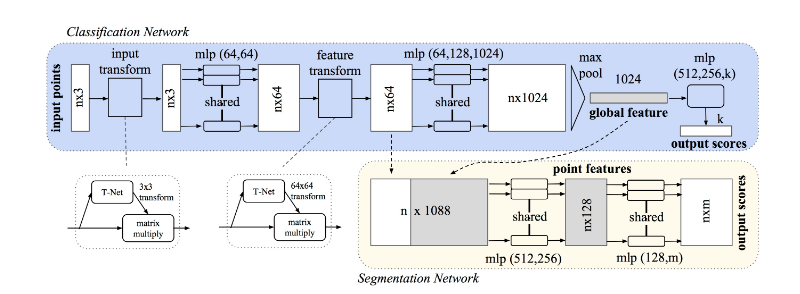

In [42]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

#Entrainement de model

In [45]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
125/125 [==============================] - 608s 5s/step - loss: 2.0037 - sparse_categorical_accuracy: 0.7181 - val_loss: 2464112395157504.0000 - val_sparse_categorical_accuracy: 0.6278
Epoch 2/10
125/125 [==============================] - 616s 5s/step - loss: 1.9189 - sparse_categorical_accuracy: 0.7447 - val_loss: 45277798637502464.0000 - val_sparse_categorical_accuracy: 0.7478
Epoch 3/10
125/125 [==============================] - 616s 5s/step - loss: 1.8493 - sparse_categorical_accuracy: 0.7642 - val_loss: 7482695168.0000 - val_sparse_categorical_accuracy: 0.7610
Epoch 4/10
125/125 [==============================] - 606s 5s/step - loss: 1.8236 - sparse_categorical_accuracy: 0.7670 - val_loss: 29.1652 - val_sparse_categorical_accuracy: 0.7533
Epoch 5/10
125/125 [==============================] - 602s 5s/step - loss: 1.7419 - sparse_categorical_accuracy: 0.7928 - val_loss: 17014.5664 - val_sparse_categorical_accuracy: 0.7059
Epoch 6/10
125/125 [==============================

#Tester le model

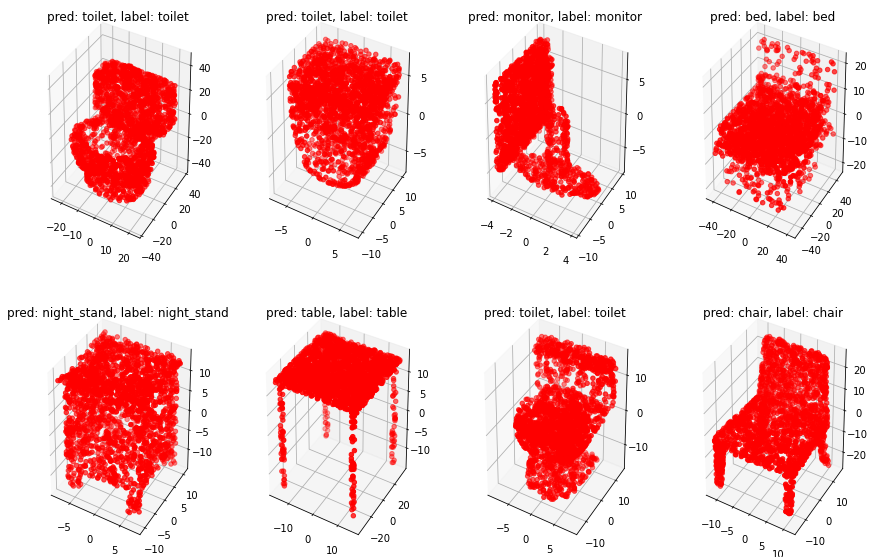

In [47]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points1 = points[:8, ...]
labels1 = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

preds1 = model.predict(points1)
preds1 = tf.math.argmax(preds1, -1)

points1 = points1.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points1[i, :, 0], points1[i, :, 1], points1[i, :, 2], color='red')
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds1[i].numpy()], CLASS_MAP[labels1.numpy()[i]]
        )
    )
    #ax.set_axis_off()
plt.show()


CONFUSION MATRIX 


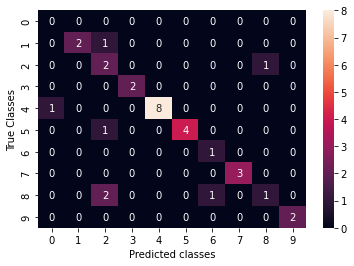

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("CONFUSION MATRIX ")
sns.heatmap(confusion_matrix(labels, preds),annot=True)
plt.ylabel('True Classes')
plt.xlabel('Predicted classes')
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80         3
           2       0.33      0.67      0.44         3
           3       1.00      1.00      1.00         2
           4       1.00      0.89      0.94         9
           5       1.00      0.80      0.89         5
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         3
           8       0.50      0.25      0.33         4
           9       1.00      1.00      1.00         2

    accuracy                           0.78        32
   macro avg       0.73      0.73      0.71        32
weighted avg       0.86      0.78      0.80        32



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
